## Imports

In [1]:
import numpy as np
import scanpy as sc 
import umap
from sklearn.manifold import SpectralEmbedding
import matplotlib.pylab as plt
from t_sne import *

c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preprocessing

### Single-cell multione gene expression

In [2]:
multiome = sc.read_h5ad("data/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")
gex = multiome[:, multiome.var["feature_types"] == "GEX"]

c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
sc.pp.highly_variable_genes(gex, n_top_genes=2500, flavor="seurat_v3") # Feature selection

c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [4]:
gex_data = gex[:, gex.var["highly_variable"]].X
gex_data.shape # should be (90k, 2500)

(90261, 2500)

In [7]:
gex_labels = gex.obs["cell_type"].values
gex_labels

['Naive CD20+ B IGKC+', 'CD14+ Mono', 'Naive CD20+ B IGKC+', 'HSC', 'Reticulocyte', ..., 'Lymph prog', 'CD8+ T naive', 'T reg', 'CD4+ T naive', 'CD8+ T naive']
Length: 90261
Categories (45, object): ['B1 B IGKC+', 'B1 B IGKC-', 'CD4+ T CD314+ CD45RA+', 'CD4+ T activated', ..., 'dnT', 'gdT CD158b+', 'gdT TCRVD2+', 'pDC']

In [27]:
np.unique(gex_labels).shape

(45,)

### Bank marketing dataset

In [ ]:
marketing_data = ...

## Evaluation

The evaluation pipeline is the follwoing:

1) Apply dimensionality reduction technique (Laplacian Eigenmaps, t-SNE, UMAP) to the data (application)

2) Compute quantitative metrics for the 2D embedding (KL divergence and Spearman's rank correlation) (quantitative metrics)

3) Plot the embedding (visualization)

4) Perform Leiden clustering on the embedding and based on cluster labels compute ARI, AMI, Homogenuity and Completeness metrics to further assess the quality of the embedding (clustering metrics)


In [41]:
import sklearn.metrics as sm
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr

def get_kld(data, embedding):
    negsqd = -pairwise_sq_distances(data)
    sigmas = find_exact_sigmas(negsqd)
    P = p_joint_probabilities(negsqd, sigmas)
    Q, _ = q_joint_probabilities(embedding)
    kld = kl_divergence(P, Q)
    return kld

def get_src(data, embedding):
    original_distances = pdist(data, metric='euclidean')
    embedded_distances = pdist(embedding, metric='euclidean')
    spearman_corr, _ = spearmanr(original_distances, embedded_distances)
    return spearman_corr

def get_quantitative_metrics(data, embedding):

    kld = get_kld(data, embedding)
    src = get_src(data, embedding)
    print("KL Divergence:", kld)
    print("Spearman's Rank Correlation:", src)
    return kld, src

def plot_embedding(embedding, labels):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    handles = []
    for i, label in enumerate(np.unique(labels)):
        handle = axs[0].scatter(embedding[labels==label, 0], embedding[labels==label, 1], s=1., label=label)
        handles.append(handle)

    axs[1].legend(handles, np.unique(labels), ncol=2)

    plt.xlabel("EMB1")
    plt.ylabel("EMB2")
    plt.show()

def get_clustering_metrics(embedding, labels):
    anndata = sc.AnnData(embedding)
    sc.pp.neighbors(anndata, use_rep="X")
    sc.tl.leiden(anndata)
    cluster_labels = anndata.obs["leiden"].values
    print("Number of Leiden clusters:", cluster_labels.shape)
    ari = sm.adjusted_rand_score(labels, cluster_labels)
    ami = sm.adjusted_mutual_info_score(labels, cluster_labels)
    homogeneity = sm.homogeneity_score(labels, cluster_labels)
    completeness = sm.completeness_score(labels, cluster_labels)
    print("""
    ARI: {}\n
    AMI: {}\n
    Homogenuity: {}\n
    Completeness: {}\n
    Avarage: {}
    """.format(ari, ami, homogeneity, completeness, (ari+ami+homogeneity+completeness)/4))
    return ari, ami, homogeneity, completeness

### t-SNE

Application

In [ ]:
def t_sne(data, n_components=2):
    embedding = ...
    return embedding

Quantitative metrics

In [ ]:
embedding = t_sne(gex_data, n_components=2)

Visualization

Clustering metrics

### Laplacian Eigenmaps

Application

In [10]:
reducer = SpectralEmbedding(n_components=2)
le_embedding = reducer.fit_transform(np.asarray(gex_data[:2000].toarray()))

In [11]:
le_embedding.shape

(2000, 2)

Quantitative metrics

In [12]:
le_kl_div, le_sp_corr = get_quantitative_metrics(np.asarray(gex_data[:2000].toarray()), le_embedding)

KL Divergence: 404454468000.7337
Spearman's Rank Correlation: 0.7549299762481274


Visualization

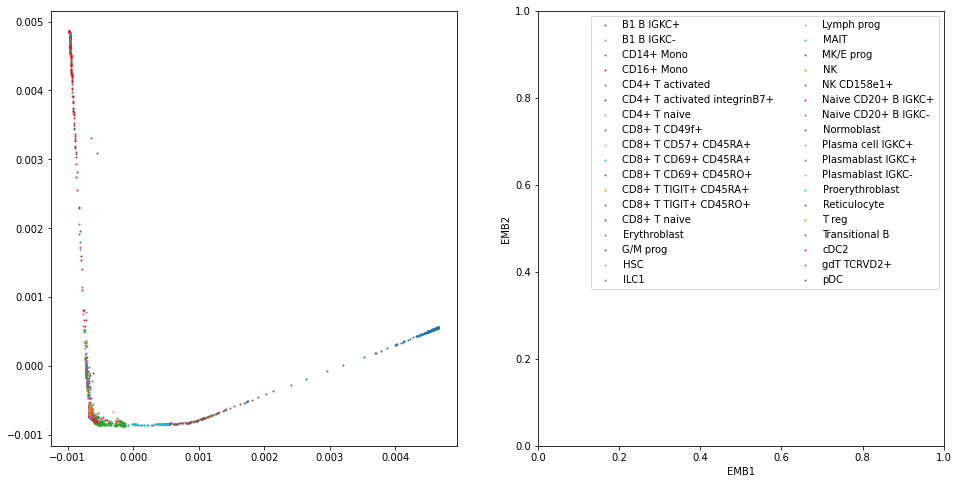

In [42]:
le_cluster_labels = plot_embedding(le_embedding, gex_labels[:2000])

Clustering metrics

In [32]:
le_ari, le_ami, le_homogenuity, le_completeness = get_clustering_metrics(gex_labels[:2000], le_cluster_labels)


    ARI: 0.21975694765371645

    AMI: 0.4728698504087835

    Homogenuity: 0.5672523630475469

    Completeness: 0.48271782214487824
    


In [42]:
# overall
print((le_ari + le_ami + le_homogenuity + le_completeness)/4)

0.43564924581373127


### UMAP

Application

In [34]:
reducer = umap.UMAP(n_components=2)
umap_embedding = reducer.fit_transform(gex_data[:5000])

Quantitative metrics

In [35]:
umap_kl_div, umap_sp_corr = get_quantitative_metrics(np.asarray(gex_data[:5000].toarray()), umap_embedding)

KL Divergence: 1313232499927.6465
Spearman's Rank Correlation: 0.7953632271206441


Visualization

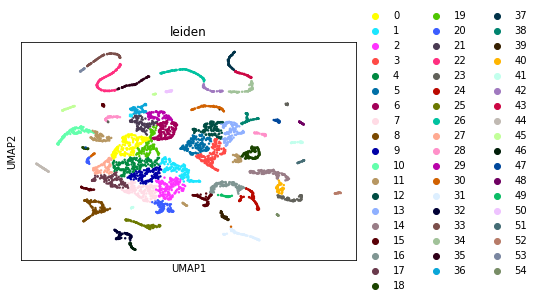

In [36]:
umap_cluster_labels = plot_embedding(umap_embedding)

Clustering metrics

In [40]:
umap_ari, umap_ami, umap_homogenuity, umap_completeness = get_clustering_metrics(gex_labels[:5000], umap_cluster_labels)


    ARI: 0.22890934884668243

    AMI: 0.5515534482377265

    Homogenuity: 0.6629262349694341

    Completeness: 0.5097989911449575
    


In [41]:
# overall
print((umap_ari + umap_ami + umap_homogenuity + umap_completeness)/4)

0.48829700579970015
